# Telco™ Project
#### Christopher Ortiz, Junior Data Scientist
***
## Summary
_In Progress_



### Contents
1. [Planning](#Planning)
2. [Acquisition](#Acquisition)
3. [Preparation](#Preparation)
4. [Exploration](#Exploration)
5. [Modeling](#Modeling)
6. [Evaluation](#Evaluation)
7. [Conclusion](#Conclusion)

# Planning
---
### Goals
1. Find drivers of customer churn
2. Accurately predict customer churn at Telco™

### Measures of success
1. Find 2 or more drivers of churn using statistical tests
2. Establish baseline accuracy
3. Outperform baseline accuracy using a classification model
4. Document insights from each stage of the data science pipeline

In [18]:
# import libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import supporting functions to acquire, prep, and split data
from acquire import get_telco_data
from prepare import telco_data_prep, preprocessed_data, data_target_split

# Initialize to ignore warnings
warnings.filterwarnings('ignore')

# Set defaults for visuals
plt.rc('figure', figsize=(16,9))
plt.rc('axes.spines', top=False, right=False)
plt.rc('patch', ec='black', force_edgecolor=True)
plt.rc('font', size=20)
sns.set(rc={'figure.figsize': (16,9)})

# Acquisition
---
### Summary
_In Progress_


<div class="alert alert-block alert-warning">
Data Cleaning Notes
    
---
    
1. Remove duplicate attributes
2. Change total_charges dtype from str -> float

<br>
    
Data Preparation Notes
    
---
1. Create encoded columns for categorical variables
2. Combine subgroups of data into a single column
3. Keep duplicate columns for data visualization, drop in modeling
</div>


To begin, we'll need to acquire our data and load it in a jupyter notebook.

In [7]:
# Load the telco data using function stored in acquire.py
df_telco = get_telco_data()

Once the data is loaded, we need to understand the context of our data. Here are few things we need to look to have a successful mvp.

1. Shape
1. Values
1. Summary Statistics

Being thorough during this process will reveal nearly everything we need to do in data prep.

#### Shape
We look at the shape of the data to understand:
1. How many rows/observations/records are in the dataset. The length of the data.
1. How many columns/features/attributes each observation has. The width of the data.

In [24]:
# Lets take a look at the shape of the data
print(f"{df_telco.shape[0]} rows, {df_telco.shape[1]} columns")

7043 rows, 24 columns


In [25]:
df_telco.head()

,payment_type_id,contract_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
0,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,DSL,Month-to-month,Mailed check
1,4,1,1,0013-MHZWF,Female,0,No,Yes,9,Yes,...,Yes,Yes,Yes,Yes,69.4,571.45,No,DSL,Month-to-month,Credit card (automatic)
2,1,1,1,0015-UOCOJ,Female,1,No,No,7,Yes,...,No,No,No,Yes,48.2,340.35,No,DSL,Month-to-month,Electronic check
3,1,1,1,0023-HGHWL,Male,1,No,No,1,No,...,No,No,No,Yes,25.1,25.1,Yes,DSL,Month-to-month,Electronic check
4,3,1,1,0032-PGELS,Female,0,Yes,Yes,1,No,...,No,No,No,No,30.5,30.5,Yes,DSL,Month-to-month,Bank transfer (automatic)


Using `.head()` we can see that some of our columns have redundant attributes and categorical atrributes. We to drop the redundant columns and create encoded columns for the categorical columns.

Also, some columns refer to a subgroup of data:

- Demographics data: partner, dependents
- Steaming Services data: tv, movies

If we can represent these attributes with a single column, we'll reduce the dimensions/complexity of our dataset.

__Values__

Looking at the values of our helps us determine which columns need to be cast for data exploration.
Let's take a look at the dtypes of each column.

In [26]:
# This is a powerful function that tells us if there are any nulls, column dtypes.
df_telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   contract_type_id          7043 non-null   int64  
 2   internet_service_type_id  7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

Wow, almost all of the columns have an `object` dtype. Lets use `.nunique()` to find out the number of unique values in each column.

In [11]:
df_telco.nunique()

payment_type_id                4
contract_type_id               3
internet_service_type_id       3
customer_id                 7043
gender                         2
senior_citizen                 2
partner                        2
dependents                     2
tenure                        73
phone_service                  2
multiple_lines                 3
online_security                3
online_backup                  3
device_protection              3
tech_support                   3
streaming_tv                   3
streaming_movies               3
paperless_billing              2
monthly_charges             1585
total_charges               6531
churn                          2
internet_service_type          3
contract_type                  3
payment_type                   4
dtype: int64

In [8]:
# I create a custom filter for columns with 3 or 4 unique values. Columns with
# 2 unique values can be represented using binary values.
object_columns = df_telco.nunique()[(df_telco.nunique() <= 4) & (df_telco.nunique() > 2)]

# Store the names of columns with 3 or 4 unique values.
object_columns = object_columns.index.to_list()

In [9]:
# Iterate over the list to see the unique values in these columns
for column in object_columns:
    print(df_telco[column].value_counts().sort_index())
    print('')

1    2365
2    1612
3    1544
4    1522
Name: payment_type_id, dtype: int64

1    3875
2    1473
3    1695
Name: contract_type_id, dtype: int64

1    2421
2    3096
3    1526
Name: internet_service_type_id, dtype: int64

No                  3390
No phone service     682
Yes                 2971
Name: multiple_lines, dtype: int64

No                     3498
No internet service    1526
Yes                    2019
Name: online_security, dtype: int64

No                     3088
No internet service    1526
Yes                    2429
Name: online_backup, dtype: int64

No                     3095
No internet service    1526
Yes                    2422
Name: device_protection, dtype: int64

No                     3473
No internet service    1526
Yes                    2044
Name: tech_support, dtype: int64

No                     2810
No internet service    1526
Yes                    2707
Name: streaming_tv, dtype: int64

No                     2785
No internet service    1526
Yes          

This is the gold we were looking for:
1. Duplicate columns
- payment_type, contract_type, and internet_service type have a corresponding __id__ column. We can use the object columns for data visualization and drop them once we're ready to model our data.
2. Feature Engineering
- streaming_movies/tv, online_security/backup, device_protection, and tech_support are what is known as __add-on products and services__. We can combine them into one or more columns.

__Summary Statistics__

Using `.describe()` we'll take a look at our summary statistics. Take special note of the column names.

In [9]:
df_telco.describe()

,payment_type_id,contract_type_id,internet_service_type_id,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2.315633,1.690473,1.872923,0.162147,32.371149,64.761692
std,1.148907,0.833755,0.737796,0.368612,24.559481,30.090047
min,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000
50%,2.000000,1.000000,2.000000,0.000000,29.000000,70.350000
75%,3.000000,2.000000,2.000000,0.000000,55.000000,89.850000
max,4.000000,3.000000,3.000000,1.000000,72.000000,118.750000


Notice that `total_charges` is not in the table. It's an `object` dtype. We'll need to cast it from str to float.

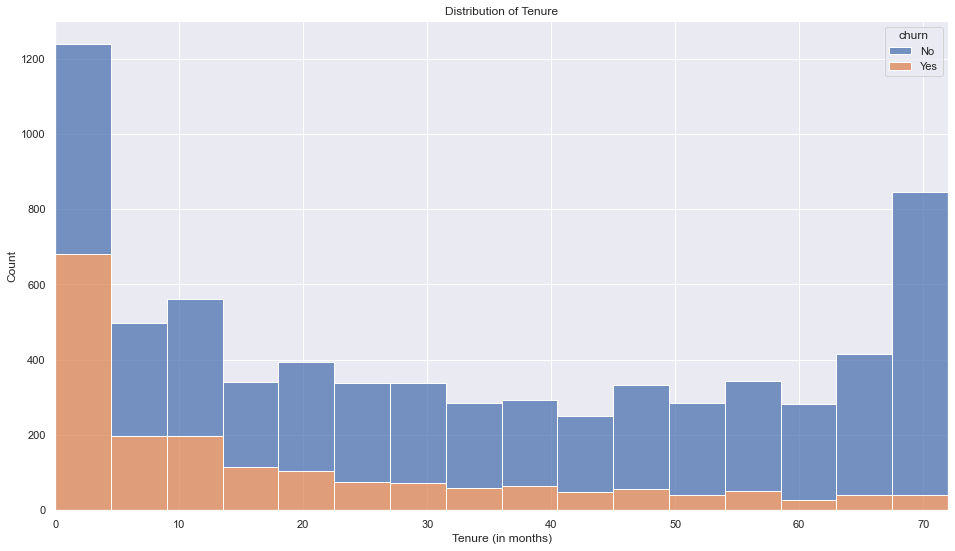

In [10]:
# Distribution of Tenure
sns.histplot(df_telco,
             x=df_telco.tenure,
             hue='churn',
             multiple='stack')

plt.title("Distribution of Tenure")
plt.xlabel('Tenure (in months)')

plt.xlim(0, df_telco.tenure.max());

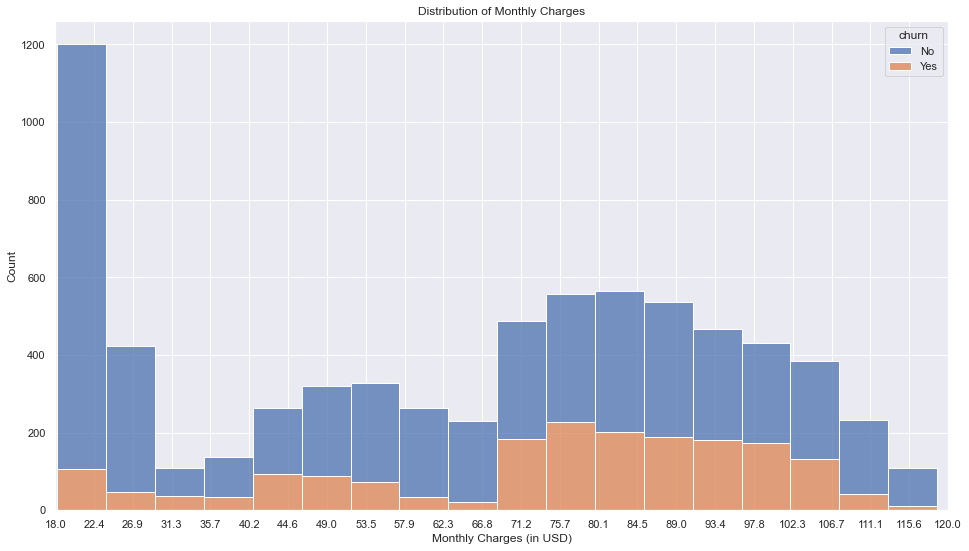

In [11]:
# Distribution of Monthly Charges
sns.histplot(data=df_telco,
            x=df_telco.monthly_charges,
            hue=df_telco.churn,
            multiple='stack')

plt.title("Distribution of Monthly Charges")
plt.xlabel('Monthly Charges (in USD)')

plt.xlim(df_telco.monthly_charges.min(),
         df_telco.monthly_charges.max())

plt.xticks(np.linspace(18, 120, 24));

In [12]:
# Service Packages
pd.crosstab(df_telco.phone_service, df_telco.internet_service_type)

internet_service_type,DSL,Fiber optic,None
phone_service,,,
No,682,0,0
Yes,1739,3096,1526


### Takeways
_In Progress_

# Preparation
---
#### Data Cleaning
- No duplicate values
- 24 attributes
    - Clean `total_charges` column
        - Convert dtype from string to float
        - Drop customers with 0 `total_charges`. #new_customers
    - Convert `churn` column values from "No"/"Yes" to 0/1
    - Rename `tenure` to `tenure_in_months`
    

#### Data Preparation
- Total_charges is a product of monthly_charges and tenure, possibly drop column.
- Create encoded attributes

In [13]:
df = telco_data_prep()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customer_id                            7043 non-null   object 
 1   tenure_in_months                       7043 non-null   int64  
 2   monthly_charges                        7043 non-null   float64
 3   total_charges                          7043 non-null   float64
 4   tenure_in_years                        7043 non-null   float64
 5   gender_Male                            7043 non-null   uint8  
 6   partner_Yes                            7043 non-null   uint8  
 7   dependents_Yes                         7043 non-null   uint8  
 8   phone_service_Yes                      7043 non-null   uint8  
 9   multiple_lines_No phone service        7043 non-null   uint8  
 10  multiple_lines_Yes                     7043 non-null   uint8  
 11  onli

In [15]:
# Scale values in iteration 2
df.describe(exclude=['object','uint8']).T

,count,mean,std,min,25%,50%,75%,max
tenure_in_months,7043.0,32.371149,24.559481,0.00,9.00,29.00,55.00,72.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
total_charges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80
tenure_in_years,7043.0,2.697402,2.046968,0.00,0.75,2.42,4.58,6.00
churn,7043.0,0.265370,0.441561,0.00,0.00,0.00,1.00,1.00


## Exploration
---
1. Statistical Analysis
    - Restate hypotheses
    - Test hypotheses
    
2. Create visuals

3. Summarize key findings

In [16]:
train, validate, test = preprocessed_data()

In [17]:
train = train.drop(columns='customer_id')
validate = validate.drop(columns='customer_id')
test = test.drop(columns='customer_id')

In [18]:
X_train, y_train = data_target_split(train)

In [19]:
X_train.sample(3)

,tenure_in_months,monthly_charges,total_charges,tenure_in_years,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,...,streaming_movies_No internet service,streaming_movies_Yes,paperless_billing_Yes,internet_service_type_Fiber optic,internet_service_type_None,contract_type_One year,contract_type_Two year,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
4221,46,30.75,1489.30,3.83,1,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
2507,18,85.45,1505.85,1.50,0,0,0,1,0,1,...,0,0,1,1,0,0,0,0,1,0
1766,15,74.45,1145.70,1.25,0,0,0,1,0,1,...,0,0,1,1,0,0,0,0,0,1


### Statistical Analysis
---

In [20]:
from scipy import stats

In [15]:
import sklearn

In [16]:
sklearn.__version__

'0.22.1'

In [21]:
confidence_interval = 0.95
alpha = 1 - confidence_interval

### Hypothesis Tests

Does a customer churn independent of whether a customer is a single household or a non-single household.

> \$H_{O}$ Churn is independent of whether a customer is a single household or a non-single household.

> \$H_{a}$ Churn is dependent on whether a customer is a single household or a non-single household.

In [66]:
singles = np.where((X_train.partner_Yes==0) & (X_train.dependents_Yes==0), 1, 0)

In [67]:
outcomes_1 = pd.crosstab(singles, y_train.churn)
outcomes_1 = outcomes_1.rename(index={0:'Not Single', 1: 'Single'}, columns={0:'No Churn', 1:'Churn'})

In [68]:
outcomes_1.index.name=''
outcomes_1.columns.name=''

In [69]:
outcomes_1

,No Churn,Churn
,,
Not Single,1650,421
Single,1247,625


In [70]:
chi2, p, degf, expected = stats.chi2_contingency(outcomes_1)

print(("Chi2: {:.2f}" \
      "\nP-Value: {:.2f}\nalpha: {:.2f}\n").format(chi2, p, alpha))

if p < alpha:
    print("P-Value is less than alpha:")
    print('Reject HO (for Ha). Churn' \
          ' is dependent on whether a customer is a single household or a non-single household.')
else:
    print('Fail to reject HO. Churn' \
          ' is independent of whether a customer is a single household or a non-single household.')

Chi2: 85.35
P-Value: 0.00
alpha: 0.05

P-Value is less than alpha:
Reject HO (for Ha). Churn is dependent on whether a customer is a single household or a non-single household.


Does a customer churn independent of whether they have a month-to-month contract or other types of contracts

> \$H_{O}$ Churn is independent of whether they have a month-to-month contract or other types of contracts.

> \$H_{a}$ Churn is dependent on whether they have a month-to-month contract or other types of contracts.

In [71]:
month_to_month_or_other = np.where((X_train['contract_type_One year']==0) & (X_train['contract_type_Two year']==0), 1, 0)

In [72]:
outcomes_2 = pd.crosstab(month_to_month_or_other, y_train.churn)

In [73]:
outcomes_2 = outcomes_2.rename(index={0:'Year/Two Year', 1: 'Month-to-Month'}, columns={0:'No Churn', 1:'Churn'})
outcomes_2.index.name=''
outcomes_2.columns.name=''

In [74]:
outcomes_2

,No Churn,Churn
,,
Year/Two Year,1672,111
Month-to-Month,1225,935


In [75]:
chi2, p, degf, expected = stats.chi2_contingency(outcomes_2)

print(("Chi2: {:.2f}" \
      "\nP-Value: {:.2f}\nalpha: {:.2f}\n").format(chi2, p, alpha))

if p < alpha:
    print("P-Value is less than alpha:")
    print('Reject HO (for Ha). Churn' \
          ' is dependent on which contract type a customer has')
else:
    print('Fail to reject HO. Churn' \
          ' is independent of which contract type a customer has')

Chi2: 686.43
P-Value: 0.00
alpha: 0.05

P-Value is less than alpha:
Reject HO (for Ha). Churn is dependent on which contract type a customer has


In [76]:
a = X_train.corr()[abs(X_train.corr()) < .01].replace(np.nan,0)

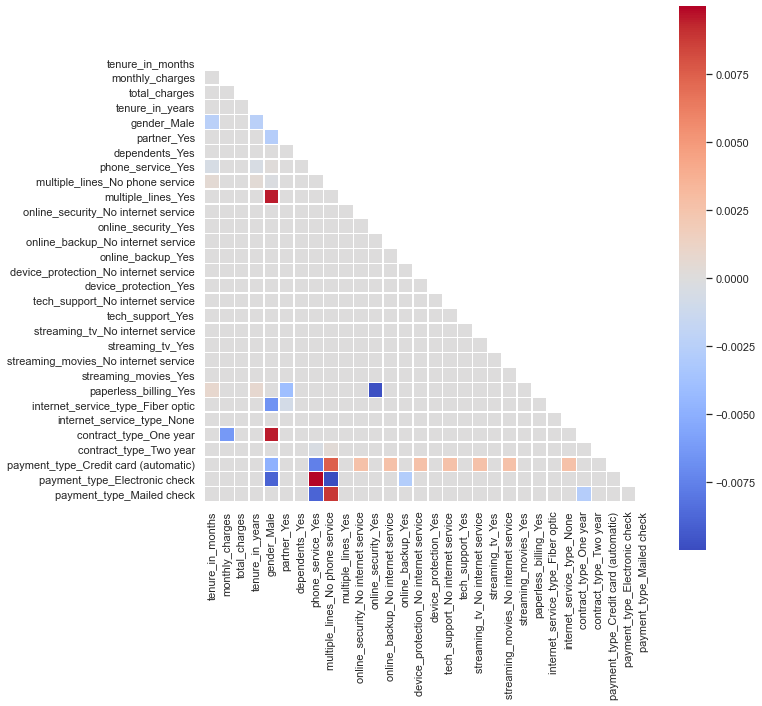

In [77]:
mask = np.zeros_like(a)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 10))
    
    ax = sns.heatmap(a, mask=mask,square=True, cmap='coolwarm', linewidths=.5)

## Modeling
---

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [37]:
X_validate, y_validate = data_target_split(validate)
X_test, y_test = data_target_split(test)

In [38]:
# Baseline Accuracy
baseline_accuracy = df.churn.value_counts(normalize=True)[0]
print(f"Baseline Accuracy: {baseline_accuracy:.2%}")

Baseline Accuracy: 73.46%


### Logistic Regression

In [107]:
logreg = LogisticRegression().fit(X_train, y_train)
logreg_train_accuracy = logreg.score(X_train, y_train)

### Decision Tree

In [108]:
forest = DecisionTreeClassifier().fit(X_train, y_train)
forest_train_accuracy = forest.score(X_train, y_train)

### Random Forest

In [109]:
rforest = RandomForestClassifier().fit(X_train, y_train)
r_forest_train_accuracy = rforest.score(X_train, y_train)

### K Nearest Neighbors

In [110]:
knn = KNeighborsClassifier().fit(X_train, y_train)
knn_train_accuracy = knn.score(X_train, y_train)

## Evaluation
---
### Training Set Accuracy

In [111]:
print(f"Baseline Accuracy --- {baseline_accuracy:.2%}")
print("")
print(f"Logistic Regression Accuracy --- {logreg_train_accuracy:.2%}")
print(f"Decision Tree Accuracy --- {forest_train_accuracy:.2%}")
print(f"Random Forest Accuracy --- {r_forest_train_accuracy:.2%}")
print(f"KNN Accuracy Accuracy --- {knn_train_accuracy:.2%}")

Baseline Accuracy --- 73.46%

Logistic Regression Accuracy --- 81.21%
Decision Tree Accuracy --- 99.82%
Random Forest Accuracy --- 99.82%
KNN Accuracy Accuracy --- 83.13%


### Validation Set Accuracy

In [112]:
logreg_validate_accuracy = logreg.score(X_validate, y_validate)
forest_validate_accuracy = forest.score(X_validate, y_validate)
r_forest_validate_accuracy = rforest.score(X_validate, y_validate)
knn_validate_accuracy = knn.score(X_validate, y_validate)

print(f"Logistic Regression Accuracy --- {logreg_validate_accuracy:.2%}")
print(f"Decision Tree Accuracy --- {forest_validate_accuracy:.2%}")
print(f"Random Forest Accuracy --- {r_forest_validate_accuracy:.2%}")
print(f"KNN Accuracy Accuracy --- {knn_validate_accuracy:.2%}")

Logistic Regression Accuracy --- 80.19%
Decision Tree Accuracy --- 73.45%
Random Forest Accuracy --- 78.42%
KNN Accuracy Accuracy --- 75.52%


### Test Set Accuracy

In [113]:
logreg_test_accuracy = logreg.score(X_test, y_test)
print(f"Logistic Regression Accuracy --- {logreg_test_accuracy:.2%}")

Logistic Regression Accuracy --- 78.57%


### Predicting Customer Churn

In [114]:
train, validate, test = preprocessed_data()

In [115]:
df_telco = pd.concat([train, validate, test], axis=0)

In [116]:
customer_ids = df_telco['customer_id']
df_telco_data = df_telco.drop(columns=['customer_id', 'churn'])
df_telco_target = df_telco.churn

In [117]:
telco_accuracy = logreg.score(df_telco_data, df_telco_target)
print(f"Logistic Regression Accuracy on Telco Data --- {telco_accuracy:.2%}")

Logistic Regression Accuracy on Telco Data --- 80.43%


### Create a  CSV file of customer churn predictions

In [50]:
prediction_of_churn = pd.DataFrame({'churn_prediction' : logreg.predict(df_telco_data)})

In [51]:
churn_probability = pd.DataFrame({'churn_probability': logreg.predict_proba(df_telco_data)[:,1]})

In [52]:
data = [customer_ids, churn_probability, prediction_of_churn]

customer_churn = pd.concat(data, axis=1)

In [118]:
customer_churn.head()

,customer_id,churn_probability,churn_prediction
0,0003-MKNFE,0.053155,0
1,0013-MHZWF,0.278553,0
2,0015-UOCOJ,0.510915,1
3,0023-HGHWL,0.779931,1
4,0032-PGELS,0.134368,0


In [53]:
# customer_churn.to_csv('customer_churn_predictions.csv')

## Conclusion
---

[Return to the top](#Telco™-Project)

## Appendix

In [ ]:
# Data Dictionaries for payments, contracts, and internet
# Key == ID number, non-zero value in row correspond to matching ID number
payments = pd.crosstab(df_telco.payment_type_id, df_telco.payment_type)
contracts = pd.crosstab(df_telco.contract_type_id, df_telco.contract_type)
internet = pd.crosstab(df_telco.internet_service_type_id, df_telco.internet_service_type)

In [ ]:
# Distribution of Tenure
sns.kdeplot(data=train,
            x=train.tenure_in_months,
            hue=train.churn,
            multiple='stack')

plt.xlabel('Tenure (in months)')
plt.xlim(0, train.tenure_in_months.max());

In [ ]:
sns.kdeplot(data=train,
            x=train.monthly_charges,
            hue=train.churn,
            multiple='stack')
plt.xlabel('Monthly Charges (in USD)')
plt.xlim(df_telco.monthly_charges.min(),
         df_telco.monthly_charges.max());

In [54]:
# sns.heatmap(abs(X_train.corr()), cmap='icefire')